# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test
import statsmodels.api as sm
from astropy.stats import sigma_clip
from scipy.optimize import fmin as fmin

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [3]:
# Write a function that computes the squared loss, and incorporates the uncertainties on the measurements
def sq_loss(y_predict, y_real, yerr):
    return (y_predict-y_real)**2/yerr**2

def likelihood_sq(y_predict, y_real, yerr):
    return -np.sum(sq_loss(y_predict, y_real, yerr))/2

Best-fit values: a=1.080 b=213.000


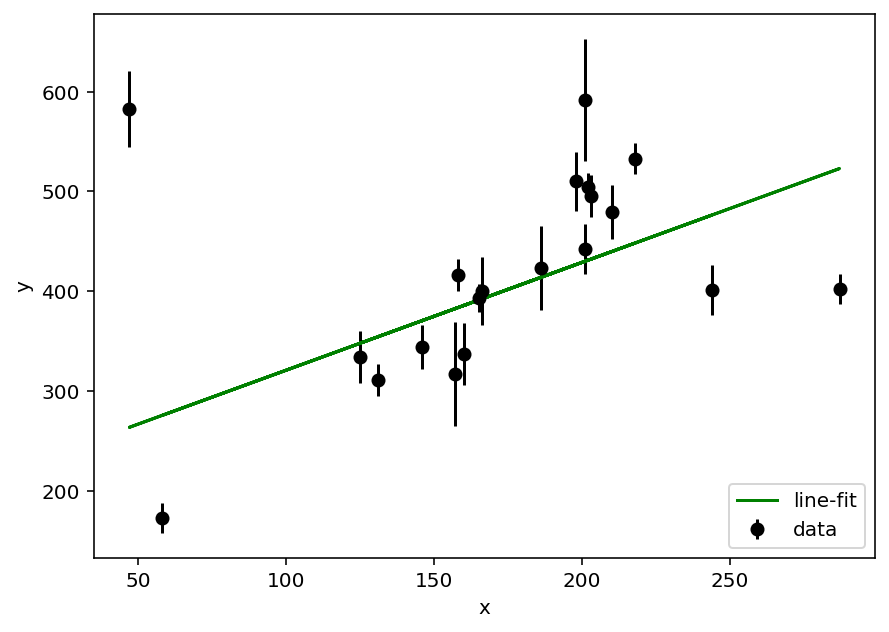

In [4]:
# Fit a line to the full sample by evaluating this likelihood on a grid of a, b
a_grid = np.linspace(0, 2, 101)
b_grid = np.linspace(0, 500, 501)
lnL_grid1 = np.zeros((len(a_grid), len(b_grid)))

for ai in range(len(a_grid)):
    for bi in range(len(b_grid)):
        ## computing the likelihood for a, b grids
        lnL_grid1[ai, bi] = likelihood_sq(a_grid[ai]*x + b_grid[bi], y, dy)
        
ab_ind1 = np.unravel_index(np.argmax(lnL_grid1, axis=None), lnL_grid1.shape)
## find the maximum likelihood
print('Best-fit values:', 'a=%.3f'%a_grid[ab_ind1[0]], 'b=%.3f'%b_grid[ab_ind1[1]])

fig, axes = plt.subplots(1, 1, figsize=(7,5))
axes.errorbar(x, y, yerr=dy, c='k', fmt='o', label='data')
axes.plot(x, a_grid[ab_ind1[0]]*x+b_grid[ab_ind1[1]], c='g', label='line-fit')
axes.legend(loc='lower right')
axes.set_xlabel('x')
axes.set_ylabel('y')
plt.show()

Number of points be rejected(3-sigma): 1
Best-fit values: a=1.260 b=176.000


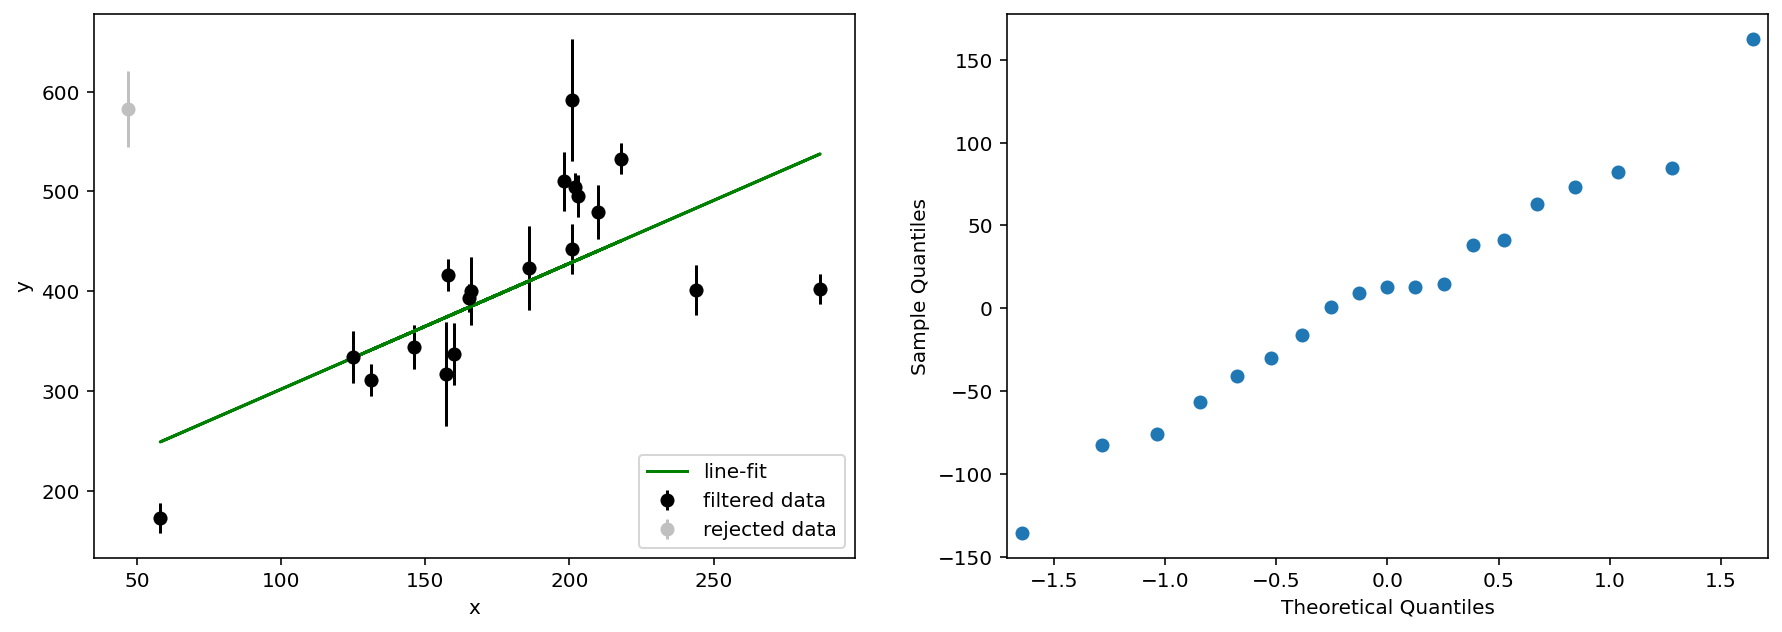

In [5]:
# Use sigma-clipping or an L-estimator for outlier rejection 
y_predict1 = a_grid[ab_ind1[0]]*x+b_grid[ab_ind1[1]]
sc_result = sigma_clip(data=y-y_predict1, sigma=3, maxiters=3)
print('Number of points be rejected(3-sigma): %d'%len(np.where(sc_result.mask)[0]))

# Fit a line to the data with outliers rejected
x_new = x[~sc_result.mask]
y_new = y[~sc_result.mask]
dy_new = dy[~sc_result.mask]
lnL_grid2 = np.zeros((len(a_grid), len(b_grid)))

for ai in range(len(a_grid)):
    for bi in range(len(b_grid)):
        lnL_grid2[ai, bi] = likelihood_sq(a_grid[ai]*x_new + b_grid[bi], y_new, dy_new)
        
ab_ind2 = np.unravel_index(np.argmax(lnL_grid2, axis=None), lnL_grid2.shape) 
print('Best-fit values:', 'a=%.3f'%a_grid[ab_ind2[0]], 'b=%.3f'%b_grid[ab_ind2[1]])

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].errorbar(x_new, y_new, yerr=dy_new, fmt='o', c='k', label='filtered data')
axes[0].errorbar(x, y, yerr=dy, fmt='o', c='silver', zorder=-1, label='rejected data')
axes[0].plot(x_new, a_grid[ab_ind2[0]]*x_new+b_grid[ab_ind2[1]], c='g', label='line-fit')
axes[0].legend(loc='lower right')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Make a QQ plot of the residuals
residuals = y_new-(a_grid[ab_ind2[0]]*x_new+b_grid[ab_ind2[1]])
sm.qqplot(residuals, ax=axes[1])
plt.show()

scipy.optimize.fmin results: a=1.965 b=70.006


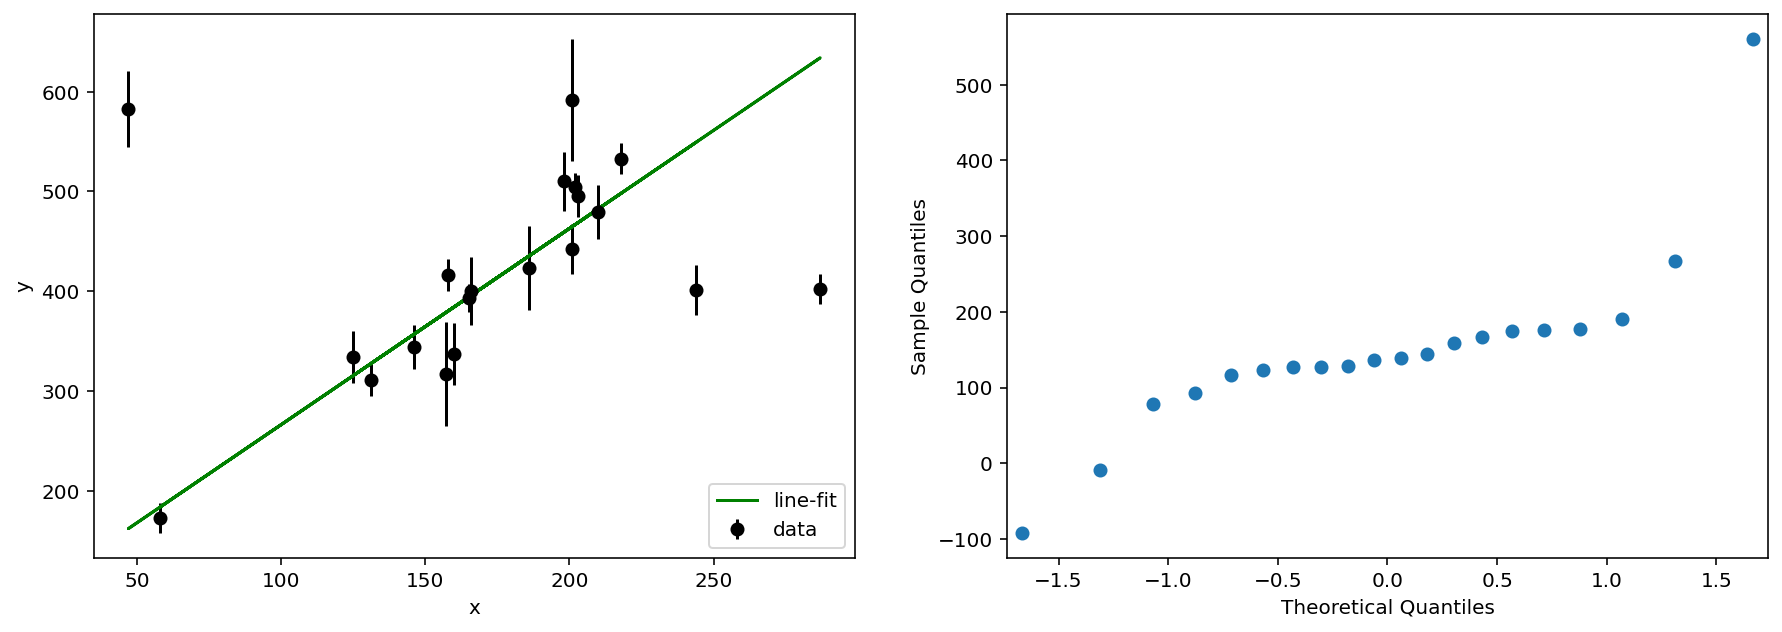

In [6]:
# Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties
def huber_loss(y_predict, y_real, yerr):
    loss = np.zeros(len(y_real))
    a = np.abs(y_predict-y_real)
    loss[np.where(a<=yerr)] = a[np.where(a<=yerr)]**2/2
    loss[np.where(a>yerr)] = (yerr*(a-yerr/2))[np.where(a>yerr)]
    return loss

def likelihood_huber(p0, x_arr, y_real, yerr):
    a, b = p0
    y_predict = a*x_arr+b
    return np.sum(huber_loss(y_predict, y_real, yerr)/(2*yerr**2))

# Now use scipy.optimize.fmin instead of a grid search, and QQ plot of the residuals
fmin_result = fmin(likelihood_huber, np.array([1., 200.]), args=(x,y,dy), disp=False)
print('scipy.optimize.fmin results: a=%.3f'%fmin_result[0],'b=%.3f'%fmin_result[1])

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].errorbar(x, y, yerr=dy, c='k', fmt='o', label='data')
axes[0].plot(x, fmin_result[0]*x+fmin_result[1], c='g', label='line-fit')
axes[0].legend(loc='lower right')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Make a QQ plot of the residuals
residuals = y-fmin_result[0]*x+fmin_result[1]
sm.qqplot(residuals, ax=axes[1])
plt.show()

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [7]:
import pandas as pd

In [8]:
ceph_data = pd.read_csv('./Cepheids.csv')
ceph_name = np.array(ceph_data['name'])
ceph_ra = np.array(ceph_data['RA0'])
ceph_dec = np.array(ceph_data['Decl0'])
ceph_cloud = np.array(ceph_data['Cloud'])
ceph_mode = np.array(ceph_data['Mode'])
ceph_W = np.array(ceph_data['W'])
ceph_logP1 = np.array(ceph_data['logP1'])
ceph_VI = np.array(ceph_data['VI'])

# Split the data
ind_LMC_F = np.where((ceph_cloud=='LMC')&(ceph_mode=='F'))[0]
ind_LMC_1 = np.where((ceph_cloud=='LMC')&(ceph_mode=='1'))[0]
ind_SMC_F = np.where((ceph_cloud=='SMC')&(ceph_mode=='F'))[0]
ind_SMC_1 = np.where((ceph_cloud=='SMC')&(ceph_mode=='1'))[0]

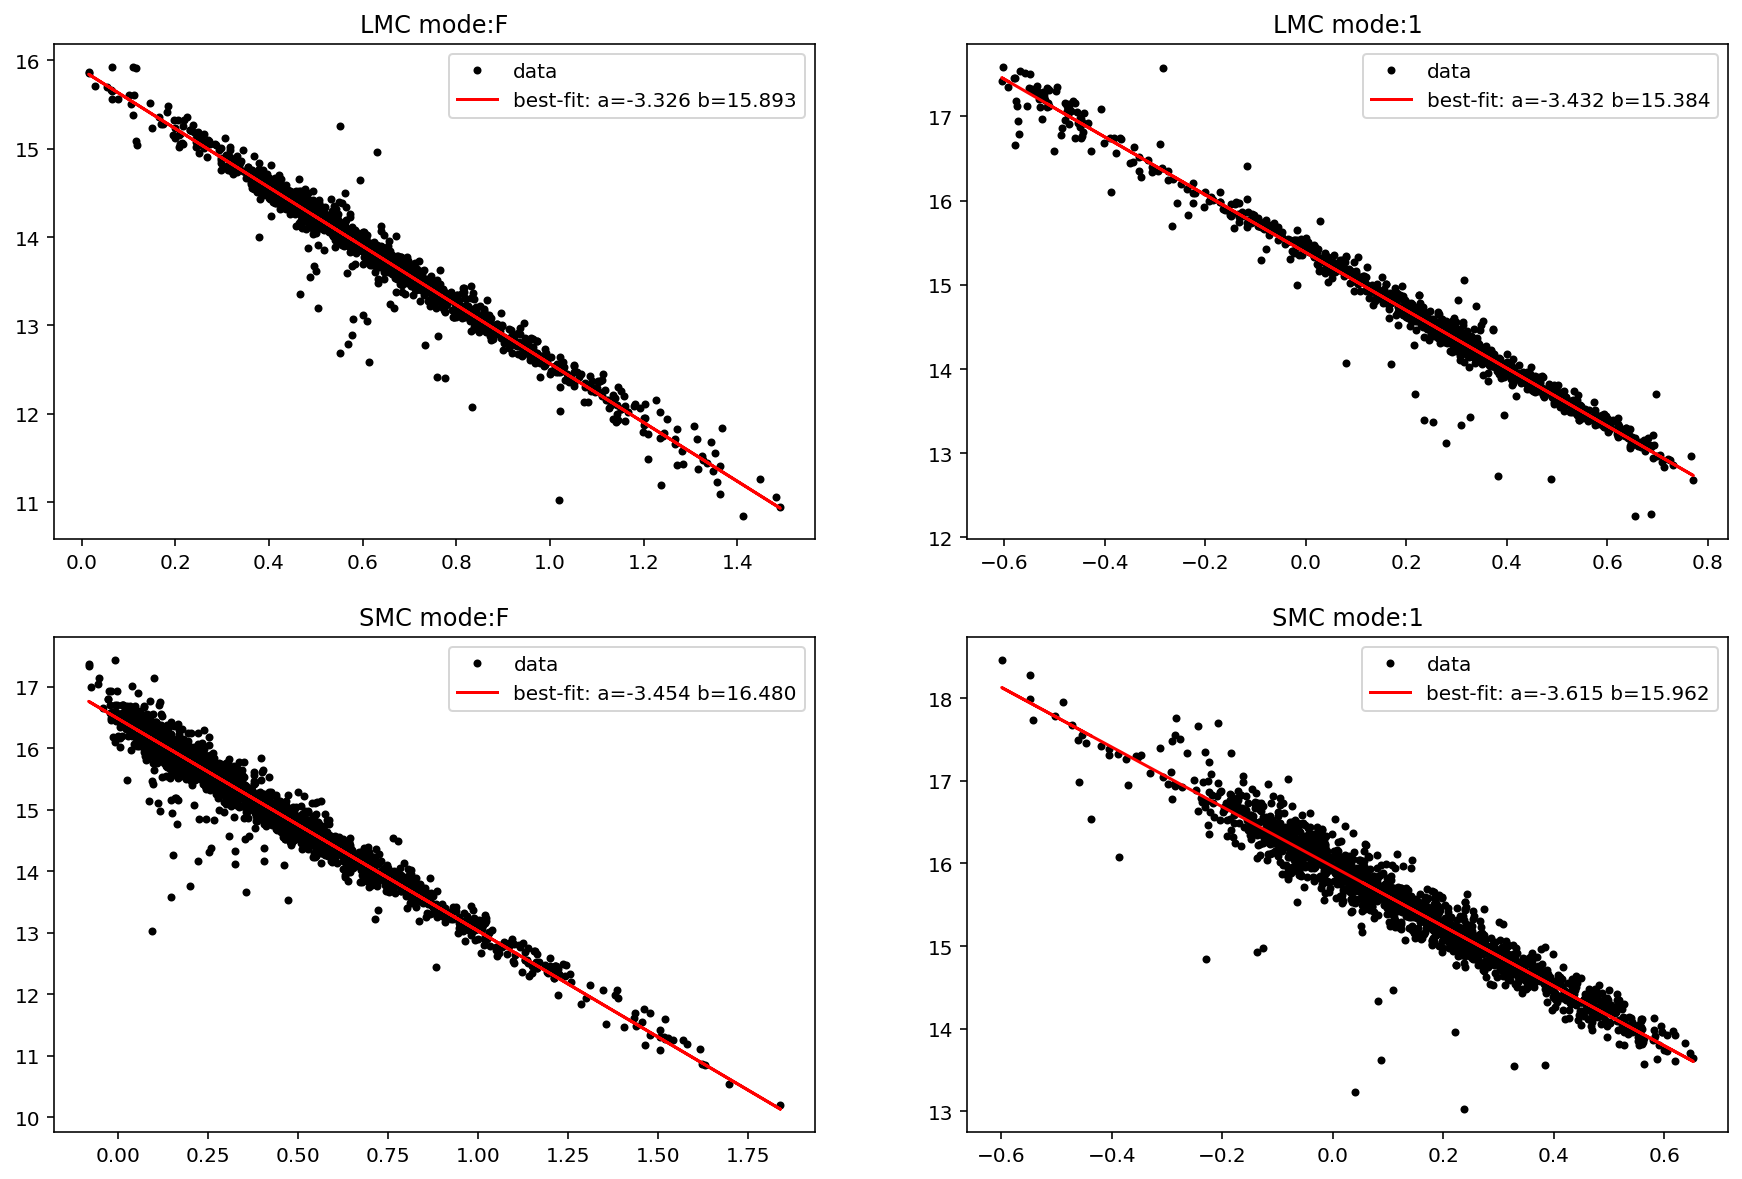

In [9]:
# Fit or estimate straight lines to each of the four samples
def likelihood_sq2(p0, x_arr, y_real):
    # squared loss without err for fmin
    a, b = p0
    y_predict = a*x_arr+b
    return np.sum((y_predict-y_real)**2)/2

fmin_LMC_F = fmin(likelihood_sq2, np.array([-3., 15.]), args=(ceph_logP1[ind_LMC_F], ceph_W[ind_LMC_F]), disp=False)
fmin_LMC_1 = fmin(likelihood_sq2, np.array([-3., 15.]), args=(ceph_logP1[ind_LMC_1], ceph_W[ind_LMC_1]), disp=False)
fmin_SMC_F = fmin(likelihood_sq2, np.array([-3., 15.]), args=(ceph_logP1[ind_SMC_F], ceph_W[ind_SMC_F]), disp=False)
fmin_SMC_1 = fmin(likelihood_sq2, np.array([-3., 15.]), args=(ceph_logP1[ind_SMC_1], ceph_W[ind_SMC_1]), disp=False)

fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0][0].set_title(r'LMC mode:F')
axes[0][0].plot(ceph_logP1[ind_LMC_F], ceph_W[ind_LMC_F], 'k.', label='data')
axes[0][0].plot(ceph_logP1[ind_LMC_F], fmin_LMC_F[0]*ceph_logP1[ind_LMC_F]+fmin_LMC_F[1], 'r', \
                label='best-fit: a=%.3f'%fmin_LMC_F[0]+' b=%.3f'%fmin_LMC_F[1])
axes[0][0].legend(loc='upper right', fontsize=10)
axes[0][1].set_title(r'LMC mode:1')
axes[0][1].plot(ceph_logP1[ind_LMC_1], ceph_W[ind_LMC_1], 'k.', label='data')
axes[0][1].plot(ceph_logP1[ind_LMC_1], fmin_LMC_1[0]*ceph_logP1[ind_LMC_1]+fmin_LMC_1[1], 'r', \
                label='best-fit: a=%.3f'%fmin_LMC_1[0]+' b=%.3f'%fmin_LMC_1[1])
axes[0][1].legend(loc='upper right', fontsize=10)
axes[1][0].set_title(r'SMC mode:F')
axes[1][0].plot(ceph_logP1[ind_SMC_F], ceph_W[ind_SMC_F], 'k.', label='data')
axes[1][0].plot(ceph_logP1[ind_SMC_F], fmin_SMC_F[0]*ceph_logP1[ind_SMC_F]+fmin_SMC_F[1], 'r', \
                label='best-fit: a=%.3f'%fmin_SMC_F[0]+' b=%.3f'%fmin_SMC_F[1])
axes[1][0].legend(loc='upper right', fontsize=10)
axes[1][1].set_title(r'SMC mode:1')
axes[1][1].plot(ceph_logP1[ind_SMC_1], ceph_W[ind_SMC_1], 'k.', label='data')
axes[1][1].plot(ceph_logP1[ind_SMC_1], fmin_SMC_1[0]*ceph_logP1[ind_SMC_1]+fmin_SMC_1[1], 'r', \
                label='best-fit: a=%.3f'%fmin_SMC_1[0]+' b=%.3f'%fmin_SMC_1[1])
axes[1][1].legend(loc='upper right', fontsize=10)
plt.show()

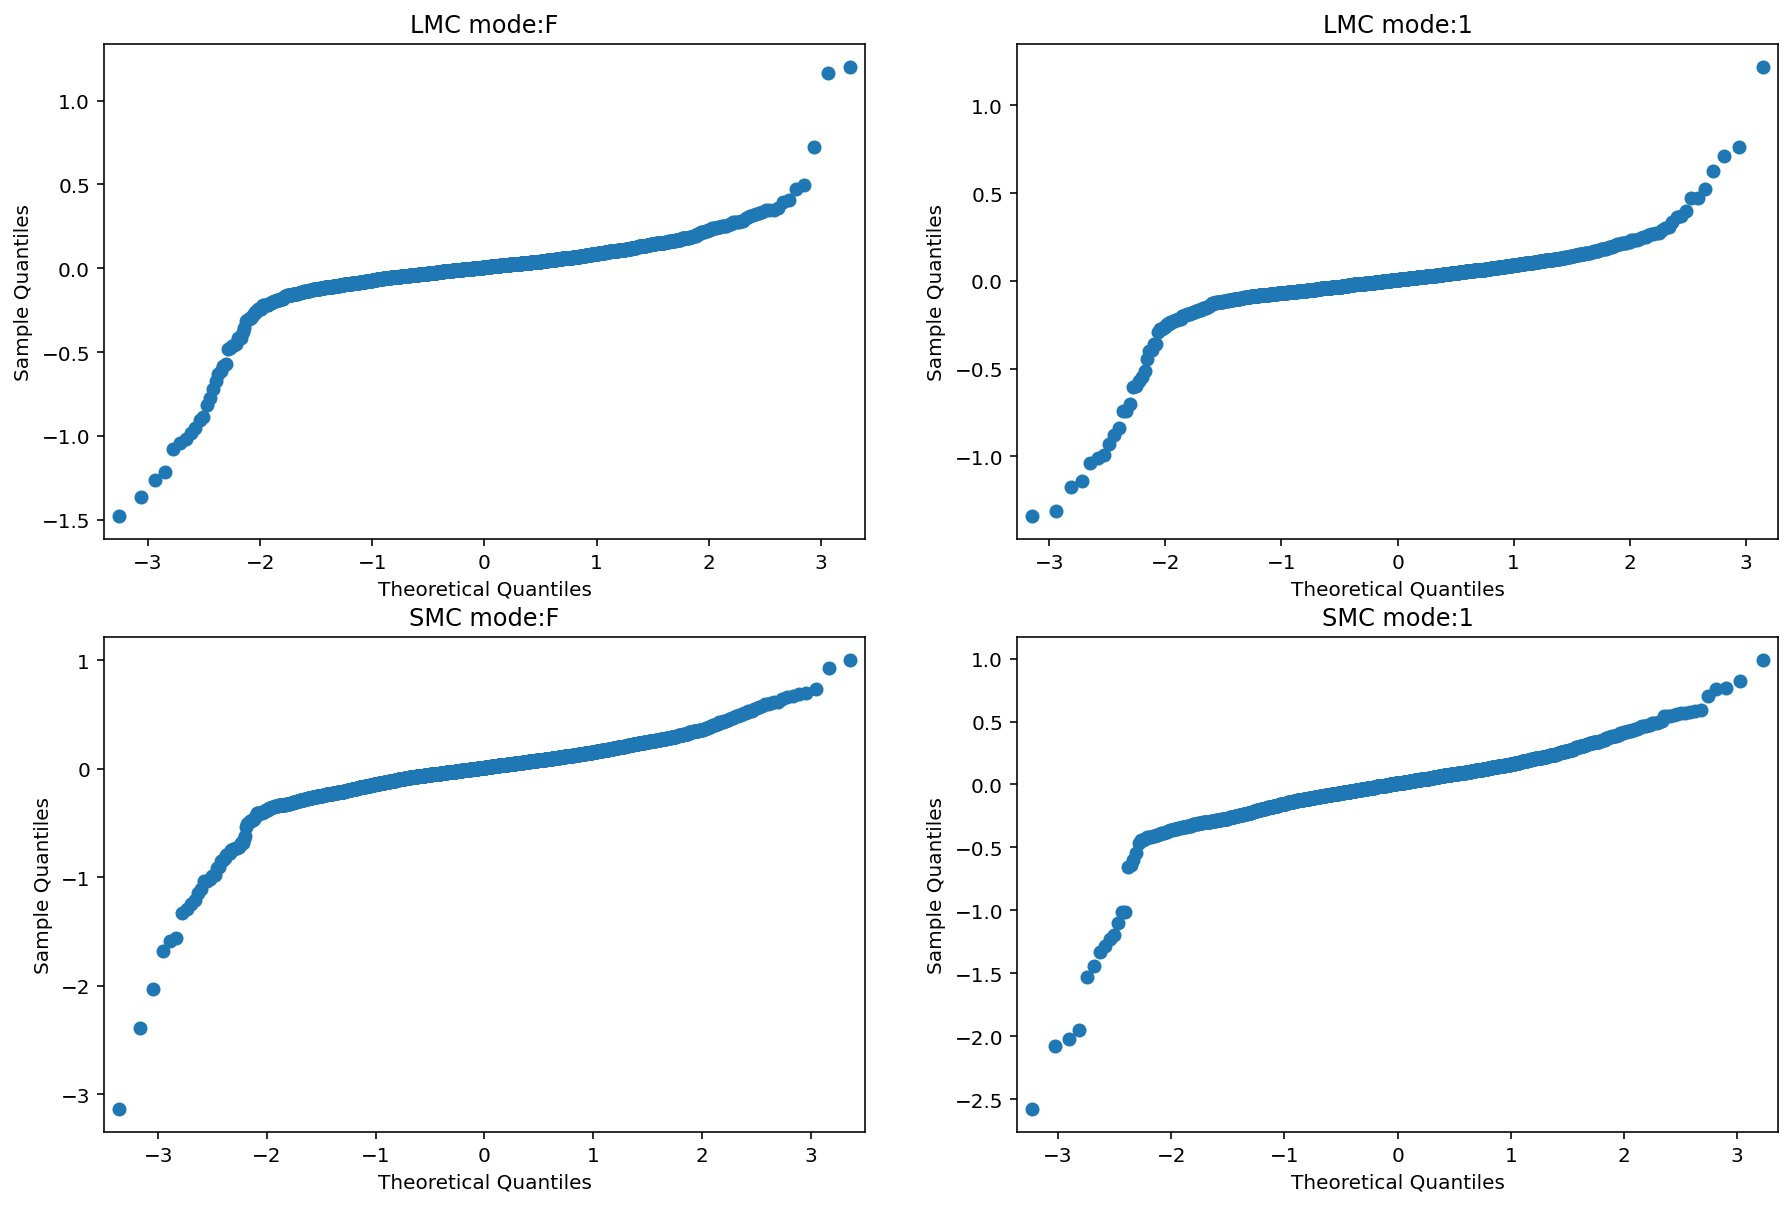

In [10]:
# Compute the residuals of each sample. Do these residuals look like a normal distribution?
res_LMC_F = ceph_W[ind_LMC_F]-(fmin_LMC_F[0]*ceph_logP1[ind_LMC_F]+fmin_LMC_F[1])
res_LMC_1 = ceph_W[ind_LMC_1]-(fmin_LMC_1[0]*ceph_logP1[ind_LMC_1]+fmin_LMC_1[1])
res_SMC_F = ceph_W[ind_SMC_F]-(fmin_SMC_F[0]*ceph_logP1[ind_SMC_F]+fmin_SMC_F[1])
res_SMC_1 = ceph_W[ind_SMC_1]-(fmin_SMC_1[0]*ceph_logP1[ind_SMC_1]+fmin_SMC_1[1])

fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0][0].set_title(r'LMC mode:F')
sm.qqplot(res_LMC_F, ax=axes[0][0])
axes[0][1].set_title(r'LMC mode:1')
sm.qqplot(res_LMC_1, ax=axes[0][1])
axes[1][0].set_title(r'SMC mode:F')
sm.qqplot(res_SMC_F, ax=axes[1][0])
axes[1][1].set_title(r'SMC mode:1')
sm.qqplot(res_SMC_1, ax=axes[1][1])
plt.show()

#### According to the plots above, the residuals are not normal distribition. Because there are outliers in the samples; and the properties of Cepheid Variables (like metallicities) are not normal distribution, thus leading to the non-normality of the Wesenheit index, further influence the distribution of the residuals.

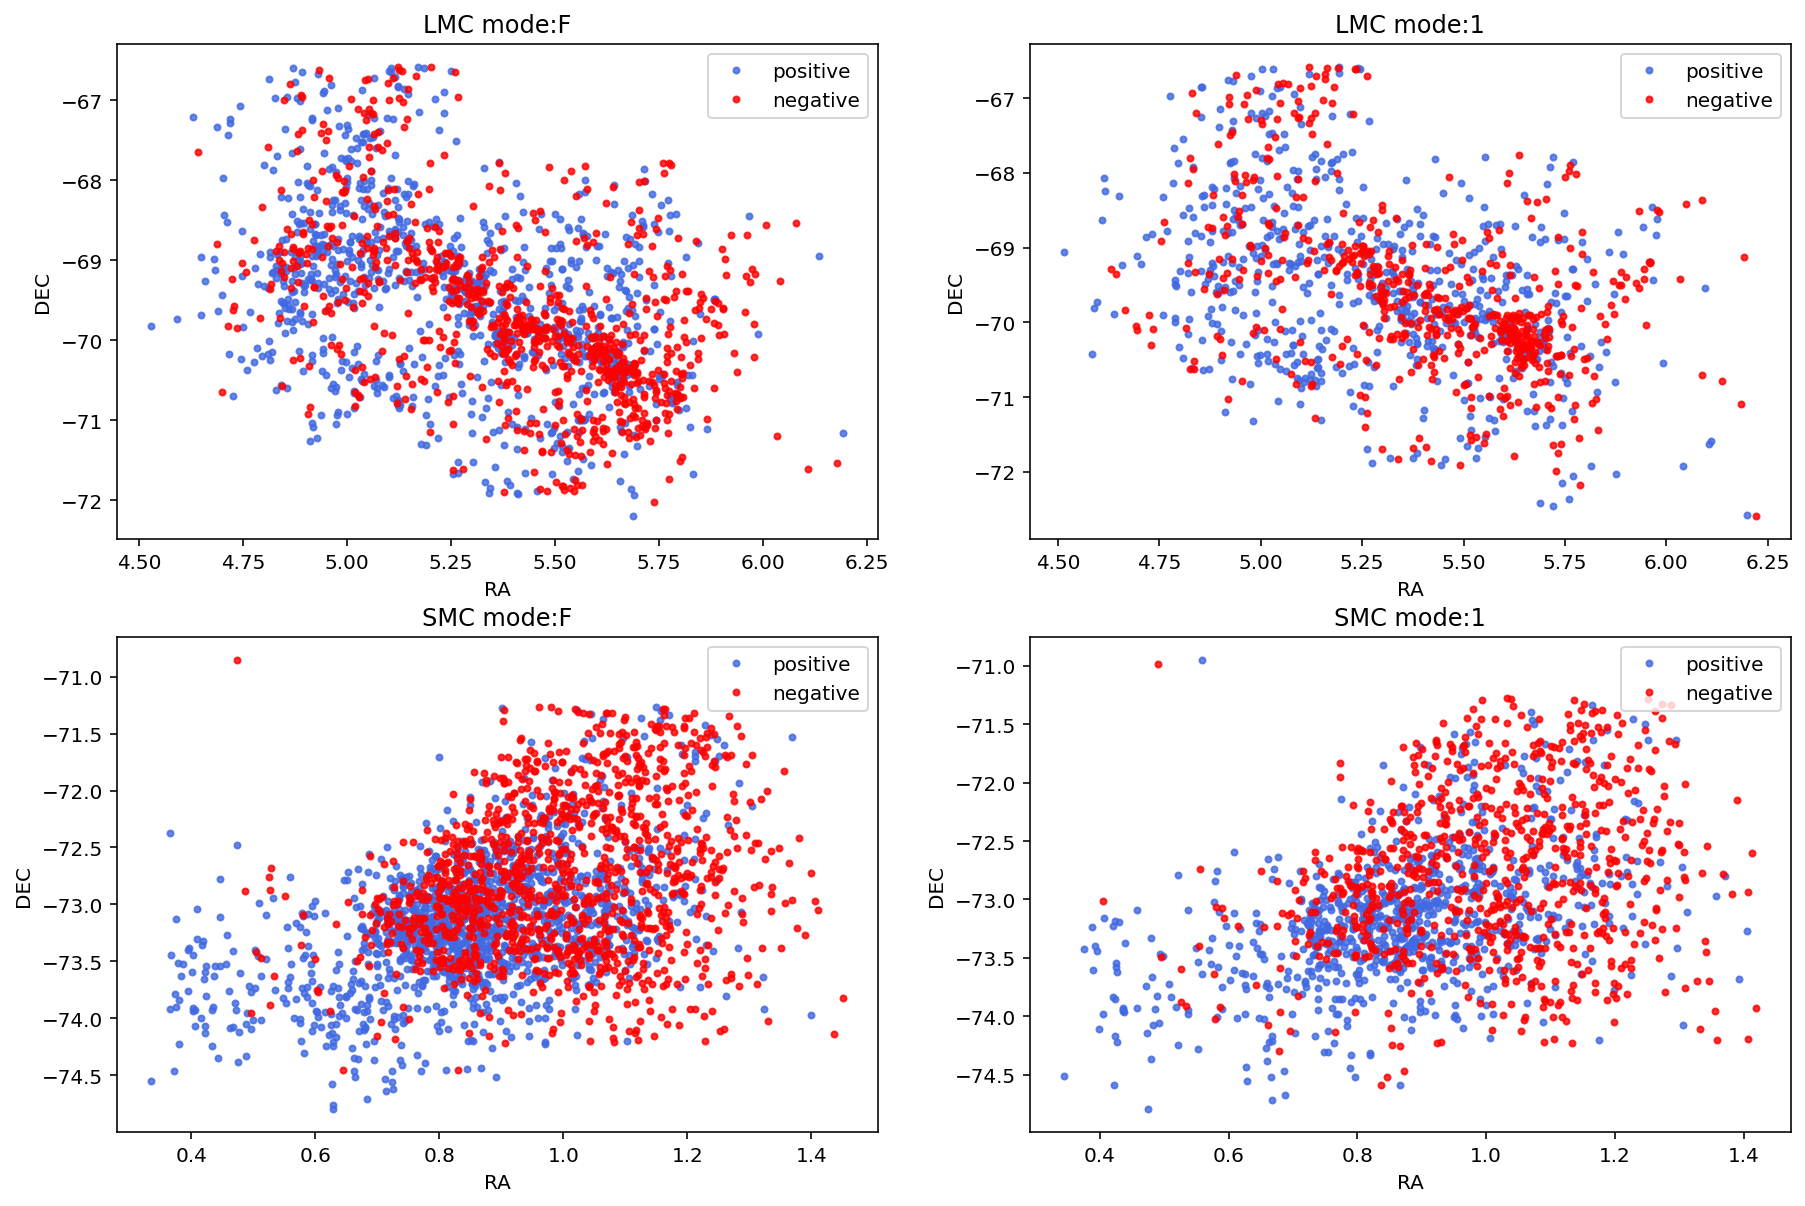

In [11]:
# Plot the residuals color coded by if they are positive or negative vs RA and Dec

fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0][0].set_title(r'LMC mode:F')
ind_LMC_F_res = np.where(res_LMC_F>0, True, False)
axes[0][0].plot(ceph_ra[ind_LMC_F][ind_LMC_F_res], ceph_dec[ind_LMC_F][ind_LMC_F_res], \
                '.', c='royalblue', alpha=0.8, label='positive')
axes[0][0].plot(ceph_ra[ind_LMC_F][~ind_LMC_F_res], ceph_dec[ind_LMC_F][~ind_LMC_F_res], \
                '.', c='r', alpha=0.8, label='negative')
axes[0][1].set_title(r'LMC mode:1')
ind_LMC_1_res = np.where(res_LMC_1>0, True, False)
axes[0][1].plot(ceph_ra[ind_LMC_1][ind_LMC_1_res], ceph_dec[ind_LMC_1][ind_LMC_1_res], \
                '.', c='royalblue', alpha=0.8, label='positive')
axes[0][1].plot(ceph_ra[ind_LMC_1][~ind_LMC_1_res], ceph_dec[ind_LMC_1][~ind_LMC_1_res], \
                '.', c='r', alpha=0.8, label='negative')
axes[1][0].set_title(r'SMC mode:F')
ind_SMC_F_res = np.where(res_SMC_F>0, True, False)
axes[1][0].plot(ceph_ra[ind_SMC_F][ind_SMC_F_res], ceph_dec[ind_SMC_F][ind_SMC_F_res], \
                '.', c='royalblue', alpha=0.8, label='positive')
axes[1][0].plot(ceph_ra[ind_SMC_F][~ind_SMC_F_res], ceph_dec[ind_SMC_F][~ind_SMC_F_res], \
                '.', c='r', alpha=0.8, label='negative')
axes[1][1].set_title(r'SMC mode:1')
ind_SMC_1_res = np.where(res_SMC_1>0, True, False)
axes[1][1].plot(ceph_ra[ind_SMC_1][ind_SMC_1_res], ceph_dec[ind_SMC_1][ind_SMC_1_res], \
                '.', c='royalblue', alpha=0.8, label='positive')
axes[1][1].plot(ceph_ra[ind_SMC_1][~ind_SMC_1_res], ceph_dec[ind_SMC_1][~ind_SMC_1_res], \
                '.', c='r', alpha=0.8, label='negative')

for px in range(2):
    for py in range(2):
        axes[px][py].set_xlabel('RA')
        axes[px][py].set_ylabel('DEC')
        axes[px][py].legend(loc='upper right', fontsize=10)

Text(0, 0.5, 'residuals')

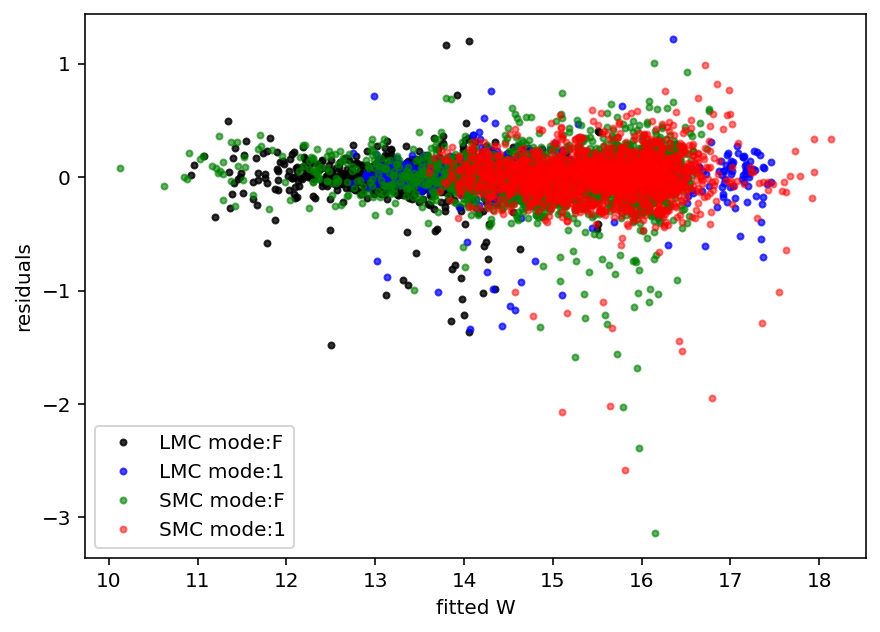

In [12]:
# plot the residuals against the fitted W values
fig, axes = plt.subplots(1, 1, figsize=(7,5))
axes.plot(fmin_LMC_F[0]*ceph_logP1[ind_LMC_F]+fmin_LMC_F[1], res_LMC_F, 'k.', label=r'LMC mode:F', alpha=0.8)
axes.plot(fmin_LMC_1[0]*ceph_logP1[ind_LMC_1]+fmin_LMC_1[1], res_LMC_1, 'b.', label=r'LMC mode:1', alpha=0.7)
axes.plot(fmin_SMC_F[0]*ceph_logP1[ind_SMC_F]+fmin_SMC_F[1], res_SMC_F, 'g.', label=r'SMC mode:F', alpha=0.6)
axes.plot(fmin_SMC_1[0]*ceph_logP1[ind_SMC_1]+fmin_SMC_1[1], res_SMC_1, 'r.', label=r'SMC mode:1', alpha=0.5)
axes.legend(loc='lower left', fontsize=10)
axes.set_xlabel('fitted W')
axes.set_ylabel('residuals')

Text(0, 0.5, 'log(P1)')

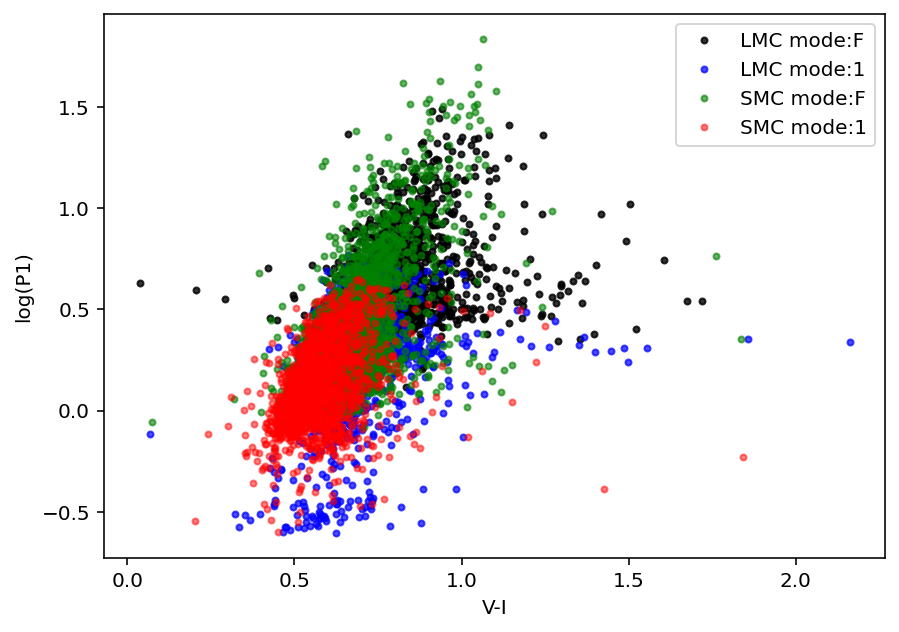

In [13]:
#  plot log(P1) vs V-I
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
axes.plot(ceph_VI[ind_LMC_F], ceph_logP1[ind_LMC_F], 'k.', label=r'LMC mode:F', alpha=0.8)
axes.plot(ceph_VI[ind_LMC_1], ceph_logP1[ind_LMC_1], 'b.', label=r'LMC mode:1', alpha=0.7)
axes.plot(ceph_VI[ind_SMC_F], ceph_logP1[ind_SMC_F], 'g.', label=r'SMC mode:F', alpha=0.6)
axes.plot(ceph_VI[ind_SMC_1], ceph_logP1[ind_SMC_1], 'r.', label=r'SMC mode:1', alpha=0.5)
axes.legend(loc='upper right', fontsize=10)
axes.set_xlabel('V-I')
axes.set_ylabel('log(P1)')

#### This plot suggests that periods of those Cepheid Variables are correlated to their color V-I. Since that color V-I is related to the energy distribution (i.e. the luminosity), this correlation potentially shows the peroid-luminosity relationship.